In [15]:
import os 
import zipfile
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

## Data Extraction

In [33]:
# Paths to the zip files
zip_files = {
    'Dataset-zip/annotation.zip': './Dataset-org/annotation',
    'Dataset-zip/images.zip': './Dataset-org/images'
}

# Create necessary directories and extract files
for zip_file_path, target_folder in zip_files.items():
    # Create the target folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)
    
    # Extract the files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)
        print(f"Extracted {zip_file_path} to {target_folder}")

print("All files extracted successfully.")

Extracted Dataset-zip/annotation.zip to ./Dataset-org/annotation
Extracted Dataset-zip/images.zip to ./Dataset-org/images
All files extracted successfully.


## Data Correction in XML annotation file

In [34]:
# Base directory containing annotation folders
annotation_dir = './Dataset-org/annotation'

# New base path to replace the <path> tag
new_base_path = r'D:\AI Client project PR-0019\Dataset-org\images\content\images'

# Iterate through all folders and XML files in the annotation directory
for root, _, files in os.walk(annotation_dir):
    for file in files:
        if file.endswith('.xml'):  # Process only XML files
            xml_file_path = os.path.join(root, file)

            try:
                # Parse the XML file
                tree = ET.parse(xml_file_path)
                root_element = tree.getroot()

                # Find and update the <path> tag
                for path_tag in root_element.iter('path'):
                    # Extract the file name from the existing path
                    file_name = os.path.basename(path_tag.text)
                    # Create the new path
                    new_path = os.path.join(new_base_path, file_name)
                    # Update the <path> tag
                    path_tag.text = new_path

                # Save the updated XML file
                tree.write(xml_file_path, encoding='utf-8', xml_declaration=True)

            except ET.ParseError:
                print(f"Skipping malformed or empty XML file: {xml_file_path}")
            except Exception as e:
                print(f"Error processing file {xml_file_path}: {e}")

print("Processing complete.")

Skipping malformed or empty XML file: ./Dataset-org/annotation\yellow rice borer\03164.xml
Processing complete.


## Visualization with annotation

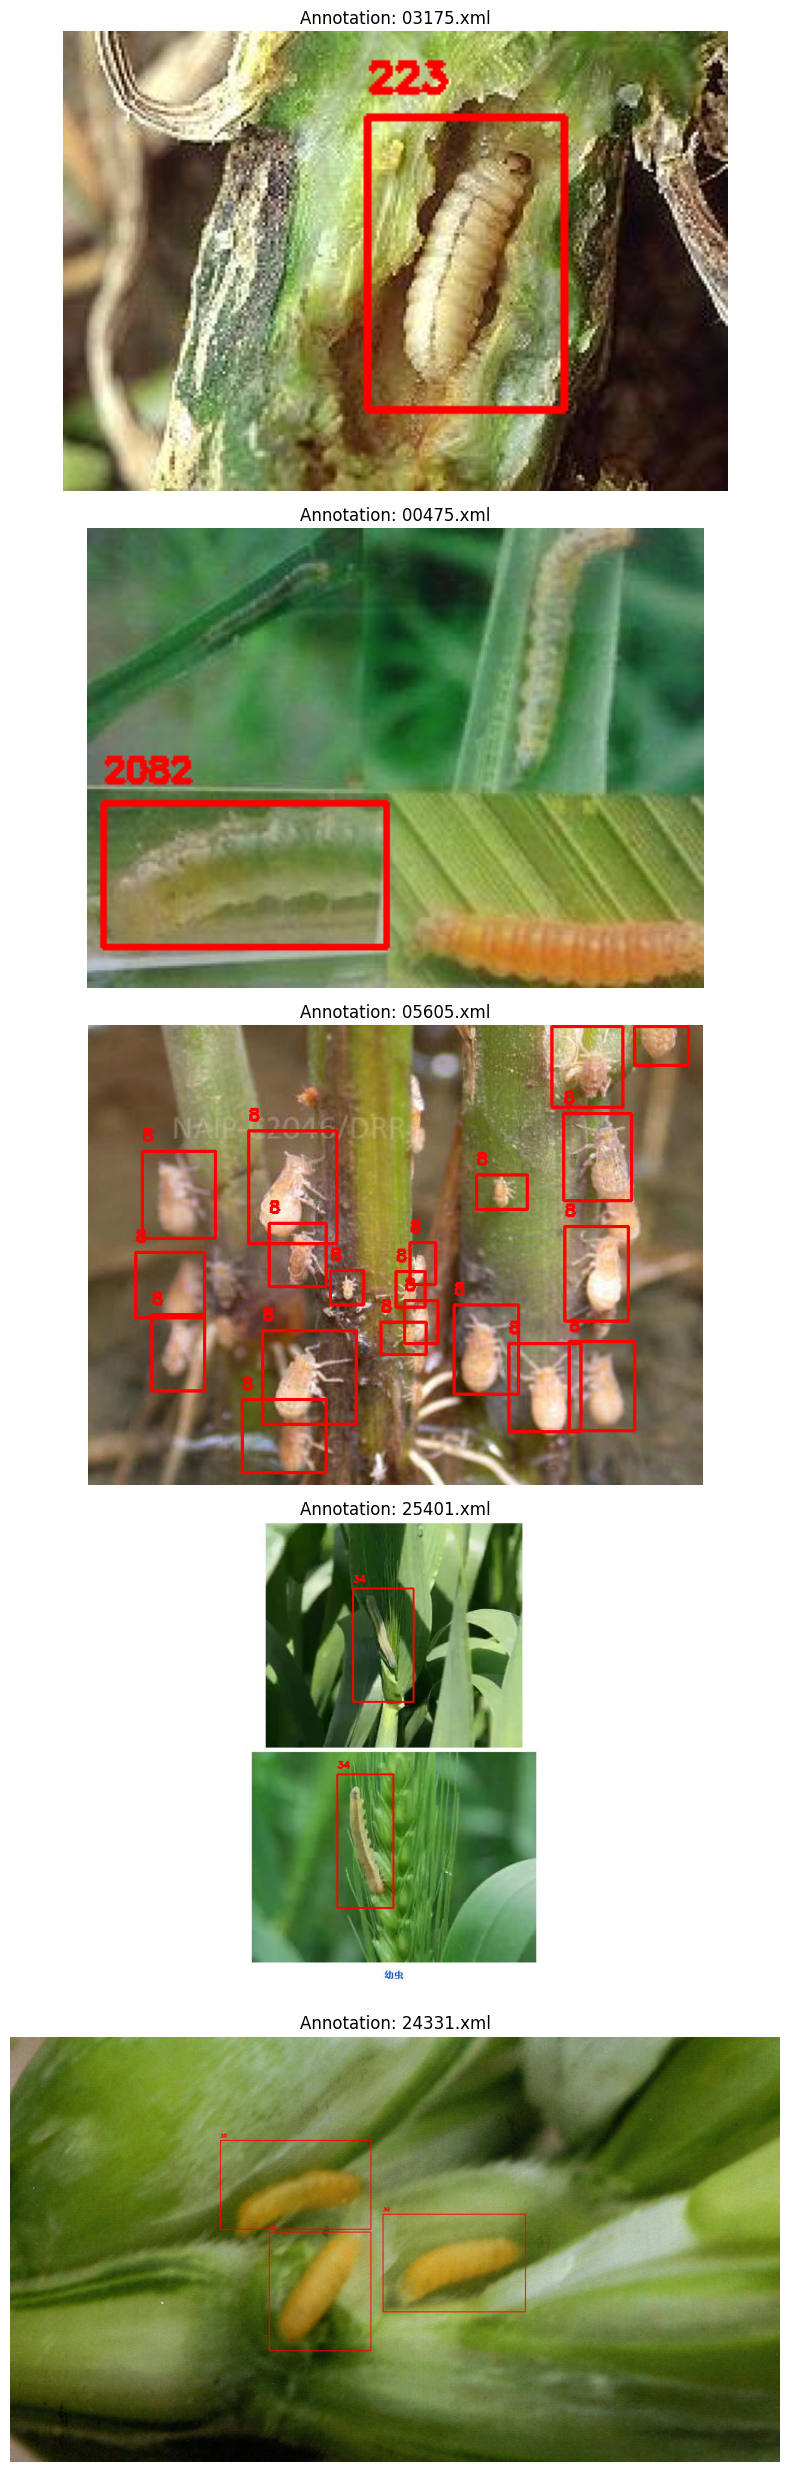

In [28]:
# Paths
annotation_folder = './Dataset-org/annotation'
image_folder = './Dataset-org/images/content/images'

def visualize_random_annotations(annotation_folder, image_folder, num_images=5):
    # Get all XML files
    xml_files = []
    for root, _, files in os.walk(annotation_folder):
        for file in files:
            if file.endswith('.xml'):
                xml_files.append(os.path.join(root, file))

    # Randomly select XML files
    selected_files = random.sample(xml_files, min(num_images, len(xml_files)))

    # Create a figure for displaying images vertically
    fig, axes = plt.subplots(len(selected_files), 1, figsize=(8, 5 * len(selected_files)))

    if len(selected_files) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, xml_file in enumerate(selected_files):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image file name
        filename = root.find('filename').text
        image_path = os.path.join(image_folder, filename)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue

        # Convert BGR (OpenCV) to RGB (Matplotlib)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Draw the bounding box
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            # Put label text
            cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display the image with annotations
        axes[i].imshow(image)
        axes[i].set_title(f"Annotation: {os.path.basename(xml_file)}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 random annotated images
visualize_random_annotations(annotation_folder, image_folder, num_images=5)


## Data Preprocessing
- extra images removed
- extra annotations removed

In [35]:
# Paths
annotation_dir = './Dataset-org/annotation'
images_dir = './Dataset-org/images/content/images'

def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in annotation and images directories
annotation_file_count = count_files(annotation_dir)
images_file_count = count_files(images_dir)

print(f"Total files in 'annotation': {annotation_file_count}")
print(f"Total files in 'images': {images_file_count}")

Total files in 'annotation': 2123
Total files in 'images': 1934


In [36]:
import os
from pathlib import Path

# Paths to annotation and images directories
annotation_dir = Path('./Dataset-org/annotation')
images_dir = Path('./Dataset-org/images/content/images')

# Collect all image and annotation file names (without extensions)
image_files = set(f.stem for f in images_dir.rglob('*') if f.is_file())
annotation_files = set(f.stem for f in annotation_dir.rglob('*.xml') if f.is_file())

# Find files that are not matched (extra files)
extra_annotations = annotation_files - image_files  # Annotations without corresponding images
extra_images = image_files - annotation_files      # Images without corresponding annotations

# Collect the files to delete
files_to_delete = []

# Delete extra annotation files (those that don't have a corresponding image)
for annotation_file in annotation_dir.rglob('*.xml'):
    if annotation_file.stem in extra_annotations:
        print(f"Deleting extra annotation: {annotation_file}")
        files_to_delete.append(str(annotation_file))
        annotation_file.unlink()  # Delete the file

# Delete extra image files (those that don't have a corresponding annotation)
for image_file in images_dir.rglob('*.*'):
    if image_file.stem in extra_images:
        print(f"Deleting extra image: {image_file}")
        files_to_delete.append(str(image_file))
        image_file.unlink()  # Delete the file

# Log deleted files (optional)
with open('deleted_files.log', 'w') as log_file:
    log_file.write('\n'.join(files_to_delete))

print(f"Deleted {len(files_to_delete)} extra files (images and annotations).")


Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01867-4.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01872-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01872-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01873-3.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-1.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-2.xml
Deleting extra annotation: Dataset-org\annotation\asiatic rice borer\01875-3.xml
Deleting extra annotation: D

In [44]:
# Paths
annotation_dir = './Dataset-org/annotation'
images_dir = './Dataset-org/images/content/images'

def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in annotation and images directories
annotation_file_count = count_files(annotation_dir)
images_file_count = count_files(images_dir)

print(f"Total files in 'annotation': {annotation_file_count}")
print(f"Total files in 'images': {images_file_count}")

Total files in 'annotation': 1916
Total files in 'images': 1916
